In [168]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import itertools 

In [4]:
import dolphindb
sess = dolphindb.session()
sess.connect("localhost", 8868, "admin", "123456")
print('DolphinDB available tables:')
sess.run('getClusterDFSTables()')

True

DolphinDB available tables:


array(['dfs://dailyETF/dailyETF', 'dfs://dailyOptions/dailyOptionsBasic',
       'dfs://dailyStock/dailyStockBasic',
       'dfs://dailyStock/dailyStockCapitalReduction',
       'dfs://dailyStock/dailyStockCompanies',
       'dfs://dailyStock/dailyStockDealers',
       'dfs://dailyStock/dailyStockForeign',
       'dfs://dailyStock/dailyStockForeignShare',
       'dfs://dailyStock/dailyStockMargin',
       'dfs://dailyStock/dailyStockRightDividend',
       'dfs://dailyStock/dailyStockRightDividendComp',
       'dfs://dailyStock/dailyStockShortSale',
       'dfs://dailyStock/dailyStockShortSaleBalance',
       'dfs://dailyStock/dailyStockShortSaleVolume',
       'dfs://dailyStock/dailyStockTradeDay',
       'dfs://daily_stock/dailyStock',
       'dfs://daily_stock_margin/dailyStockMargin',
       'dfs://daily_tfe/tickTFE', 'dfs://feature/indicator',
       'dfs://futTaifex/futTaifex',
       'dfs://test_indicator_tfe/testIndicator'], dtype='<U44')

In [5]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [6]:
import config as cfg

In [7]:
#TODO: switch to ddb twse index 
twse = pd.read_msgpack('/data/dataset/twse.msgpack')
twse.head()

/home/cyyen/miniconda3/envs/stock_path_tracker/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


,open,high,low,close,order_buy,order_sell,volume
date,,,,,,,
2005-07-11,6255.40,6305.61,6249.41,6298.86,88271.0,98780.0,93877.0
2005-07-12,6337.50,6365.76,6337.50,6358.81,86565.0,111912.0,101703.0
2005-07-13,6360.60,6406.99,6352.21,6377.09,80802.0,120531.0,106134.0
2005-07-14,6403.08,6427.32,6375.75,6418.35,92496.0,114781.0,106806.0
2005-07-15,6428.44,6454.33,6410.59,6410.59,88827.0,124306.0,106727.0


# quantization: 2012-11-22 ~ 2020-04-15
- TODO: add maturity dates before December 2012
- size of cell: 100 
- rounding: take floor

In [8]:
df = twse[cfg.D_START:][['close']].copy()
df['close_prev'] = df.close.shift(1)

In [9]:
df['prc_qtz'] = df.close_prev // cfg.SIZE_CELL * cfg.SIZE_CELL
df['delta'] = df.prc_qtz.diff()

In [10]:
settlements = pd.to_datetime(pd.read_csv('settlement_txf.csv').settlement).dt.date.tolist()
df['maturity'] = df.index.where(df.index.isin(settlements)).to_series().fillna(method='bfill').values
d2m = df.groupby('maturity').size().sort_index().tolist()
df['d2m'] = sum([list(reversed(range(d))) for d in d2m], []) + [np.nan] * (df.shape[0] - sum(d2m))
df = df[cfg.D_START: cfg.D_END]

df.dropna(inplace=True)
df.sort_index(ascending=True, inplace=True)

## example: 2015-07-01 ~ 2015-07-14

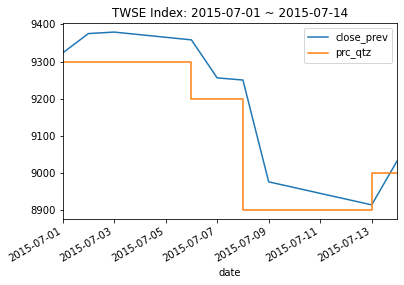

In [159]:
# vis
d_start, d_end = '2015-07-01', '2015-07-14'
df_plot = df[d_start: d_end]
ax = df_plot[['close_prev']].plot(title=f'TWSE Index: {d_start} ~ {d_end}')
df_plot[['prc_qtz']].plot(drawstyle='steps', ax=ax)

# Distribution of changes in cell

## histogram 

Text(0.5, 1.0, '#(cells)')

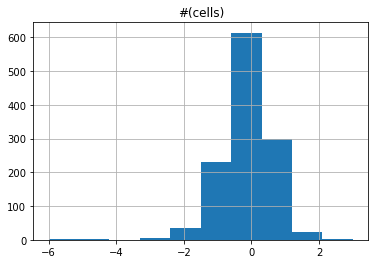

In [12]:
ax = df.delta.div(cfg.SIZE_CELL).hist()
ax.set_title('#(cells)')

## quantile

In [13]:
df_quantile = df.delta.div(cfg.SIZE_CELL).quantile([0, 0.025, 0.25, 0.5, 0.75, 0.975, 1]).to_frame('delta').T
df_quantile.columns = ['min', "2.5%", '25%', 'median', '75%', '97.5%', 'max']
df_quantile

,min,2.5%,25%,median,75%,97.5%,max
delta,-6.0,-2.0,0.0,0.0,1.0,1.0,3.0


## extreme cases

In [14]:
df_extreme_pos = df.query(f'(delta > 2*{cfg.SIZE_CELL})')
df_extreme_pos.sort_index()

,close,close_prev,prc_qtz,delta,maturity,d2m
date,,,,,,
2018-02-22,10662.38,10714.44,10700.0,300.0,2018-03-21,18.0
2018-11-01,9844.74,9802.13,9800.0,300.0,2018-11-21,14.0
2018-12-04,10083.54,10137.87,10100.0,300.0,2018-12-19,11.0


In [15]:
df_extreme_neg = df.query(f'(delta < -2*{cfg.SIZE_CELL})')
df_extreme_neg.sort_index()

,close,close_prev,prc_qtz,delta,maturity,d2m
date,,,,,,
2015-07-09,8914.13,8976.11,8900.0,-300.0,2015-07-15,3.0
2015-08-24,7410.34,7786.92,7700.0,-300.0,2015-09-16,17.0
2015-08-25,7675.64,7410.34,7400.0,-300.0,2015-09-16,16.0
2016-11-10,9152.18,8943.20,8900.0,-300.0,2016-11-16,4.0
2018-02-07,10551.54,10404.00,10400.0,-500.0,2018-02-21,4.0
2018-10-12,10045.81,9806.11,9800.0,-600.0,2018-10-17,3.0
2018-12-07,9760.88,9684.72,9600.0,-300.0,2018-12-19,8.0


## other figures in the slides

In [165]:
df = get_df()

<ipython-input-165-5b195cbacb59>:1: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  df = get_df()


In [195]:
df_prob_plot = (df.groupby('delta_cell').size() / df.shape[0]).to_frame('prob').T
df_prob_plot

delta_cell,-2.0,-1.0,0.0,1.0,2.0
prob,0.035391,0.190123,0.50535,0.246914,0.022222


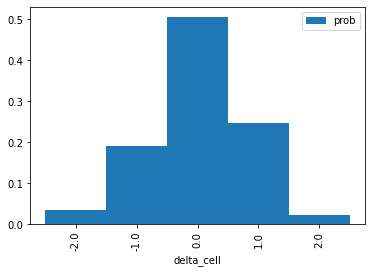

In [201]:
df_prob_plot.T.plot(kind='bar', width=1)

# compute joint probabilty

- currently only calcualte for $\tau \leq 9$, because of huge computing demand and memory

# Cost distribution
- $OptPrc_t$: the settlePrice of t-1

# Profit

In [205]:
df_cost = get_cost(df, cfg.CUTOFF_COST)
df_cost = df_cost[df_cost.lambd.map(lambda x: x.is_integer())]
df_cost.head(10)

,d2m,lambd,opt_price
0,0.0,-33.0,3350.0
1,0.0,-32.0,3250.0
2,0.0,-31.0,3145.0
3,0.0,-30.0,3045.0
4,0.0,-29.0,2945.0
5,0.0,-28.0,2850.0
6,0.0,-27.0,2750.0
7,0.0,-26.0,2650.0
8,0.0,-25.0,2550.0
9,0.0,-24.0,2450.0


# Optimization

In [16]:
from optimize import *

In [17]:
df = get_df()
prob_delta_cell = get_prob_single_day(df)
df_cost = get_cost(df, cfg.CUTOFF_COST)

<ipython-input-17-f52f42a393ce>:1: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  df = get_df()


In [18]:
var_lambda, var_tau = 2, 8
optimize(var_lambda, var_tau, df_cost, prob_delta_cell)

64.0 29.0


-22.025193985344337

# try brute force

In [19]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [20]:
import matplotlib.pylab as plt
from matplotlib.ticker import MaxNLocator

In [21]:
from optimize import *
import config as cfg

In [22]:
n_tau = 10
n_lambd = 10
cutoff_cost = cfg.CUTOFF_COST

In [23]:
df = get_df()

<ipython-input-23-5b195cbacb59>:1: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  df = get_df()


In [24]:
PROB = np.zeros((n_tau, n_lambd))
prob_delta_cell = get_prob_single_day(df)
for var_tau in range(n_tau):
    for var_lambda in range(n_lambd):
        PROB[var_tau, var_lambda] = get_realizations(var_lambda, var_tau).pipe(get_prob, prob_delta_cell)

In [25]:
PROFIT = np.array([cal_profit(var_lambda) for var_lambda in range(n_lambd)]).reshape(1, n_lambd)

In [26]:
df_cost = get_cost(df, cutoff_cost)
df_cost = df_cost[df_cost.lambd.map(lambda x: x.is_integer())]
COST = df_cost.query(f'(d2m<{n_tau}) and (0 <= lambd < {n_lambd})').pivot(index='d2m', columns='lambd', values='opt_price').to_numpy()

In [180]:
pd.DataFrame(PROB).stack().reset_index().rename(columns={'level_0': 'tau', 'level_1': 'lambd', 0: 'prob'})

,tau,lambd,prob
0,0,0,0.505350
1,0,1,0.246914
2,0,2,0.022222
3,0,3,0.000000
4,0,4,0.000000
...,...,...,...
95,9,5,0.029279
96,9,6,0.012906
97,9,7,0.004798
98,9,8,0.001499


In [182]:
pd.DataFrame(COST).stack().reset_index().rename(columns={'level_0': 'tau', 'level_1': 'lambd', 0: 'cost'}).head(10)

,tau,lambd,cost
0,0,0,56.50
1,0,1,9.45
2,0,2,0.70
3,0,3,0.30
4,0,4,0.20
5,0,5,0.20
6,0,6,0.10
7,0,7,0.10
8,0,8,0.10
9,0,9,0.10


In [176]:
pd.DataFrame(PROFIT)

,0,1,2,3,4,5,6,7,8,9
0,-100,0,100,200,300,400,500,600,700,800


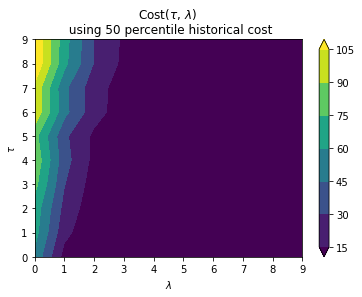

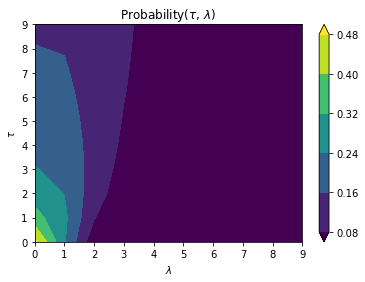

In [183]:
ax_cost = plt.figure().gca()
cs_cost = ax_cost.contourf(COST, extend='both')
ax_cost.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.colorbar(cs_cost)
_ = plt.xlabel('$\lambda$')
_ = plt.ylabel('$\\tau$')
_ = plt.title(f'Cost($\\tau$, $\lambda$) \n using {cfg.CUTOFF_COST*100:.0f} percentile historical cost')
plt.show()

# prob
ax_prob = plt.figure().gca()
cs_prob = ax_prob.contourf(PROB, extend='both')
ax_prob.xaxis.set_major_locator(MaxNLocator(integer=True))
_ = plt.colorbar(cs_prob)
_ = plt.xlabel('$\lambda$')
_ = plt.ylabel('$\\tau$')
_ = plt.title('Probability($\\tau$, $\lambda$)')
plt.show()

In [28]:
obj = np.zeros((n_tau, n_lambd))
for tau in range(n_tau):
    for lambd in range(n_lambd):
        obj[tau, lambd] = PROB[tau, lambd] * PROFIT[0, lambd] - COST[tau, lambd]
tau_star, lambd_star = obj.argmax()//n_lambd, obj.argmax() % n_lambd
print(tau_star, lambd_star)

9 4


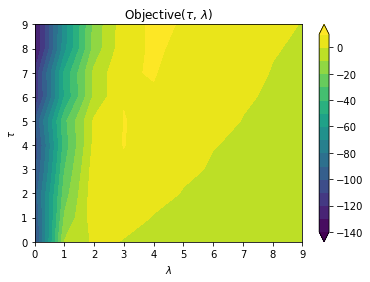

In [29]:
ax_obj = plt.figure().gca()
cs_obj = ax_obj.contourf(obj, levels=np.arange(obj.min()//10*10, (obj.max()//10+1)*10,10), extend='both')
ax_obj.xaxis.set_major_locator(MaxNLocator(integer=True))
_ = plt.colorbar(cs_obj)
_ = plt.xlabel('$\lambda$')
_ = plt.ylabel('$\\tau$')
_ = plt.title('Objective($\\tau$, $\lambda$)')
plt.show()

In [30]:
df_obj = pd.DataFrame(obj).sort_index(ascending=False)
df_policy = pd.DataFrame({
    "tau": df_obj.index.astype(int),
    "lambd": df_obj.idxmax(axis=1).astype(int),
    "PnL": df_obj.max(axis=1)
})

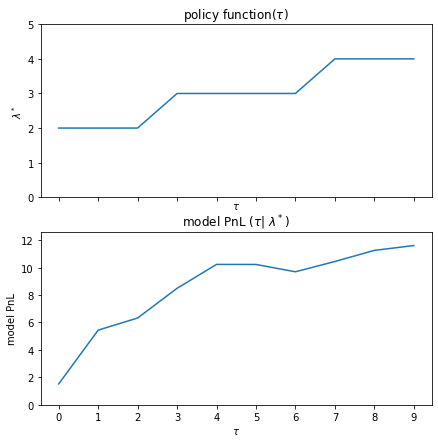

In [31]:
# optimal lambda given tau
fig, (ax_policy, ax_pnl) = plt.subplots(2,1,figsize=(7,7), sharex=True)
_ = ax_policy.plot(df_policy.tau, df_policy.lambd)
_ = ax_policy.set_ylim(0, df_policy.lambd.max()+1)
_ = ax_policy.set_xlabel('$\\tau$')
_ = ax_policy.set_ylabel('$\lambda^*$')
_ = ax_policy.set_title('policy function($\\tau$)')

# pnl given optimal lambda
_ = ax_pnl.plot(df_policy.tau, df_policy.PnL)
_ = ax_pnl.set_ylim(0, df_policy.PnL.max()+1)
_ = ax_pnl.set_xlabel('$\\tau$')
_ = ax_pnl.set_ylabel('model PnL')
_ = ax_pnl.set_title('model PnL ($\\tau$| $\\lambda^*$)')

for ax in [ax_policy, ax_pnl]:
    _ = ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    _ = ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# backtest
- ~~buy at ask / sell at bid~~
- purchase at bid and sell at ask
- payoff($\tau$) = min(max($p_0$ - $pstrike_{\tau-1}$, 0), 100) - ($pc(bid)_{\lambda^*, \tau-1}$-$pc(ask)_{\lambda^*+1, \tau-1}$)
    - limitation: 成本用前一天的收盤 option 價格
    - if no price at that strike, ignore the rows

In [32]:
import dolphindb
sess = dolphindb.session()
sess.connect("localhost", 8868, "admin", "123456")
sess.run('''
dailyOptionsBasic = loadTable("dfs://dailyOptions", `dailyOptionsBasic);
txo = select * from dailyOptionsBasic where Contract==`TXO order by Date asc;
''')

True

In [157]:
def get_PnL_given_tau_lambda(df, tau, lambd):
    df_backtest = df.query(f'(d2m=={tau})').maturity.reset_index()
    df_backtest['tau'] = tau
    df_backtest['lambd'] = lambd
    df_backtest = df_backtest.merge(df.close.reset_index().rename(columns={'date': 'maturity', 'close': 'prc_maturity'}), on='maturity', how='left')
    df_backtest = df_backtest.merge(df.prc_qtz.reset_index().rename(columns={'prc_qtz': 'prc_base'}), on='date', how='left')
    df_backtest['prc_strike'] = df_backtest.prc_base + df_backtest.lambd * cfg.SIZE_CELL
    df_backtest = pd.DataFrame([add_opt_purchase_sell_prc(row) for idx, row in df_backtest.iterrows()])
    df_backtest.head()

    missing_ratio = 1-df_backtest[['tau', 'lambd','date', 'prc_maturity', 'prc_strike', 'prc_opt_purchase', 'prc_opt_sell']].dropna().shape[0] / df_backtest.shape[0]
    print(f'\n[INFO][(tau, lambda) = ({tau}, {lambd})] there are {missing_ratio*100:.2f}% missing due to no option price at the strikes we want')

    df_pnl_real = df_backtest[['tau', 'lambd','date', 'prc_maturity', 'prc_strike', 'prc_opt_purchase', 'prc_opt_sell']].dropna()
    df_pnl_real['profit'] = (df_pnl_real.prc_maturity - df_pnl_real.prc_strike).map(lambda x: min(max(x, 0), cfg.SIZE_CELL)) 
    df_pnl_real['cost'] = df_pnl_real.prc_opt_purchase - df_pnl_real.prc_opt_sell
    df_pnl_real['PnL'] = df_pnl_real.profit - df_pnl_real.cost
    df_pnl_real[['tau', 'lambd', 'profit', 'cost', 'PnL']]
    return df_pnl_real

In [164]:
df = get_df()
collector_PnL_real = []
for tau in range(10):
    for lambd in range(10):
        df_PnL_sub = get_PnL_given_tau_lambda(df, tau, lambd)
        collector_PnL_real.append(df_PnL_sub)
df_PnL_real = pd.concat(collector_PnL_real)

<ipython-input-164-05242ab36b4b>:1: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  df = get_df()



[INFO][(tau, lambda) = (0, 0)] there are 26.67% missing due to no option price at the strikes we want

[INFO][(tau, lambda) = (0, 1)] there are 26.67% missing due to no option price at the strikes we want

[INFO][(tau, lambda) = (0, 2)] there are 26.67% missing due to no option price at the strikes we want

[INFO][(tau, lambda) = (0, 3)] there are 38.33% missing due to no option price at the strikes we want

[INFO][(tau, lambda) = (0, 4)] there are 40.00% missing due to no option price at the strikes we want

[INFO][(tau, lambda) = (0, 5)] there are 53.33% missing due to no option price at the strikes we want

[INFO][(tau, lambda) = (0, 6)] there are 56.67% missing due to no option price at the strikes we want

[INFO][(tau, lambda) = (0, 7)] there are 61.67% missing due to no option price at the strikes we want

[INFO][(tau, lambda) = (0, 8)] there are 68.33% missing due to no option price at the strikes we want

[INFO][(tau, lambda) = (0, 9)] there are 75.00% missing due to no option

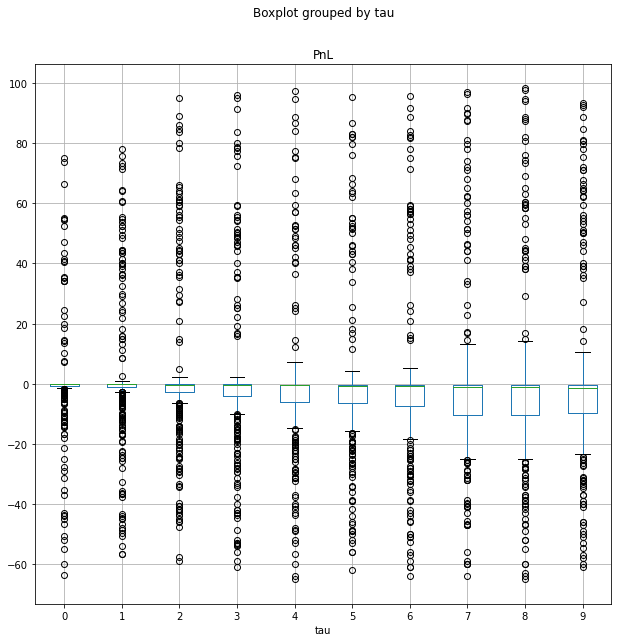

In [170]:
df_PnL_real.boxplot(column='PnL', by='tau', figsize=(10, 10))